In [1]:
# Install for Cantonese tokenization
pip install pycantonese

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.9 MB/s eta 0:00:00


label
written_chinese    210
cantonese           99
mixed               95
neutral             45
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


C: 0.5, dev_acc: 0.7556
test_acc: 0.7333
Development baseline accuracy:	0.5111
Testing baseline accuracy:	0.4444


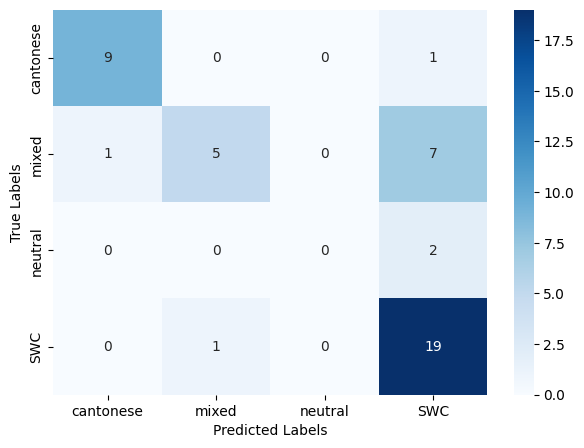

In [6]:
import numpy
import pandas as pd

from scipy import stats
from sklearn import dummy
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from pycantonese import segment    # For Cantonese tokenization
from matplotlib import pyplot
import seaborn

SEED = 731

def tokenization(sentence: str) -> list:
    return segment(sentence)

data = pd.read_csv("data_annotated.tsv", delimiter="\t", encoding="utf-8")

# Print the data distribution among the four labels
print(data["label"].value_counts())

# Encode the labels as integers
encoder = preprocessing.LabelEncoder()
label = encoder.fit_transform(data.label)

# Enconde the text data features
vectorizer = feature_extraction.text.CountVectorizer(
    encoding="utf-8", tokenizer=tokenization, min_df=3, max_df=.9
)
textdata = vectorizer.fit_transform(data.text)

# Splitting the data
textdata_train, textdata_other, label_train, label_other = (
    model_selection.train_test_split(
        textdata, label, test_size=.2, random_state=SEED
))
textdata_dev, textdata_test, label_dev, label_test = (
    model_selection.train_test_split(
        textdata_other, label_other, test_size=.5, random_state=SEED
))

# Fitting the model
logreg = linear_model.LogisticRegression(
    solver="liblinear", penalty="l1", C=0.5
)
logreg.fit(textdata_train, label_train)

# Looping over a range of values of C to find the value that maximizes the
# development accuracy
max_c = 0
max_dev_acc = 0
for C in [.1, .2, .5, 1., 2., 5., 10., 20., 50.]:
    logreg = linear_model.LogisticRegression(
        solver="liblinear", penalty="l1", C=C
    )
    logreg.fit(textdata_train, label_train)
    dev_acc = metrics.accuracy_score(label_dev, logreg.predict(textdata_dev))
    if dev_acc > max_dev_acc:
        max_dev_acc = dev_acc
        max_c = C
print(f"C: {max_c}, dev_acc: {max_dev_acc:.4f}")

# Using `max_c` to train the model again
logreg = linear_model.LogisticRegression(
    solver="liblinear", penalty="l1", C=max_c
)
logreg.fit(textdata_train, label_train)
test_acc = metrics.accuracy_score(label_test, logreg.predict(textdata_test))
print(f"test_acc: {test_acc:.4f}")

# Comparing with a baseline model
dummy_model = dummy.DummyClassifier()
dummy_model.fit(textdata_train, label_train)
dummy_dev_acc = metrics.accuracy_score(
    label_dev, dummy_model.predict(textdata_dev)
)
print(f"Development baseline accuracy:\t{dummy_dev_acc:.4f}")
dummy_test_acc = metrics.accuracy_score(
    label_test, dummy_model.predict(textdata_test)
)
print(f"Testing baseline accuracy:\t{dummy_test_acc:.4f}")

# Generating a heatmap
label_pred = logreg.predict(textdata_test)
confusion_matrix = metrics.confusion_matrix(label_test, label_pred)

class_names = ['cantonese', 'mixed', 'neutral', 'SWC']

pyplot.figure(figsize=(7, 5))
seaborn.heatmap(
    confusion_matrix, annot=True, cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('True Labels')
pyplot.show()